In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import re
import string
import spacy
import colorlover as cl
import random
import shap

from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from plotly.subplots import make_subplots
from spacy import displacy
from nltk.tokenize import TreebankWordTokenizer as twt
from nltk.tokenize import TweetTokenizer as twt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
dev_data = pd.read_csv('data/dev.csv')

Columns (112,114,121,125,157,168,186,188,206,208,217,229,231,232,233,235,237,241,244,246,247,249,250,251,268,270,271,280,282,286,288,289,291,305,310,312,313,315,316,318,319,323,324,327,328,329,331,333,335,336,338,342,344,348,350,352,353,355,356,358,359,361) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
data = pd.concat([train_data, test_data, dev_data], ignore_index=True)

In [4]:
data.columns

Index(['id', 'context', 'is_mult_event', 'annotations/0/events/0/event_id',
       'annotations/0/events/0/event_type',
       'annotations/0/events/0/Trigger/text/0/0',
       'annotations/0/events/0/Trigger/start/0/0',
       'annotations/0/events/0/Trigger/entity_id/0',
       'annotations/0/events/0/Treatment/text/0/0',
       'annotations/0/events/0/Treatment/start/0/0',
       ...
       'annotations/0/events/1/Subject/Race/entity_id/0',
       'annotations/0/events/1/Subject/text/1/0',
       'annotations/0/events/1/Subject/start/1/0',
       'annotations/0/events/1/Subject/entity_id/1',
       'annotations/0/events/0/Treatment/Route/text/1/1',
       'annotations/0/events/0/Treatment/Route/start/1/1',
       'annotations/0/events/0/Treatment/Combination/0/Drug/text/1/1',
       'annotations/0/events/0/Treatment/Combination/0/Drug/start/1/1',
       'annotations/0/events/0/Subject/Age/text/0/1',
       'annotations/0/events/0/Subject/Age/start/0/1'],
      dtype='object', length

In [5]:
# Selected columns to be retained and rename them
selected_columns = ['id', 'context', 'annotations/0/events/0/event_type', 
                    'annotations/0/events/0/Trigger/text/0/0', 
                    'annotations/0/events/0/Treatment/Drug/text/0/0','annotations/0/events/0/Effect/text/0/0']
new_names = ['id', 'context', 'event_type', 'trigger_text', 'drug', 'drug_effect']
df = data[selected_columns].rename(columns=dict(zip(selected_columns, new_names)))

In [6]:
sentiment_mapping = {'Adverse_event': 1, 'Potential_therapeutic_event': 0}
df['sentiment'] = df['event_type'].map(sentiment_mapping)

In [7]:
df.sample(5)

id                                            context  \
1529  20338114_2  The other patient developed transient intraope...   
336   20412003_2  Although this combination agent has been assoc...   
1410   8031432_1  Recurrent hypotension immediately after seizur...   
795   15190230_2  In this case report, we present clinical and l...   
1323   9634122_4  We describe a patient with androgen-independen...   

         event_type trigger_text                        drug  \
1529  Adverse_event    developed                 epinephrine   
336   Adverse_event      induced                     TMP-SMX   
1410  Adverse_event           in               nortriptyline   
795   Adverse_event        after  pegylated interferon alpha   
1323  Adverse_event        after                   flutamide   

                                            drug_effect  sentiment  
1529  transient intraoperative hypertension immediately          1  
336                                      hepatotoxicity          1  
1410   Recurrent hypotension immediately after seizures          1  
795                                      acute dystonia          1  
1323  PSA continued to decrease for a period of 15 m...          1

In [8]:
pharmaco_vigil_stopwords = [
    'patient', 'patients', 'event', 'drug', 'medication', 'treatment',
    'symptoms', 'dose', 'dosage', 'safety', 'efficacy', 'monitoring',
    'pharmacovigilance', 'reporting', 'healthcare', 'study', 'trial', 'outcome',
    'population', 'exposure', 'protocol', 'review', 'analysis', 'information',
    'evaluation', 'surveillance', 'benefit', 'assessment', 'labeling', 'label',
    'labelled', 'unlabelled', 'off-label', 'contraindications', 'contraindicated',
    'interaction', 'interactions', 'concomitant', 'co-administration', 'indications',
    'precaution', 'precautions', 'administration', 'route', 'dosage', 'pharmacokinetics',
    'pharmacodynamics', 'absorption', 'distribution', 'metabolism', 'elimination',
    'bioavailability', 'half-life', 'clearance', 'efficiency', 'effectiveness', 'monitor',
    'monitoring', 'protocol', 'endpoint', 'protocol', 'standard', 'randomization',
    'randomized', 'controlled', 'placebo', 'baseline', 'efficacy', 'primary',
    'secondary', 'endpoint', 'conclusion', 'summary', 'analysis', 'study', 'result',
    'results', 'data', 'analysis', 'statistics', 'significant', 'p-value',
    'confidence', 'interval', 'review', 'systematic', 'meta-analysis', 'literature',
    'case', 'series', 'report', 'summary', 'benefit-risk', 'balance', 'advice',
    'recommendation', 'guideline', 'guidelines', 'regulatory', 'agency',
    'pharmaceutical', 'company', 'manufacturer', 'labeling', 'product', 'package',
    'insert', 'leaflet', 'contraindication', 'interaction', 'overdose', 'warning',
    'precaution', 'adverse', 'event', 'reaction', 'pregnancy', 'lactation',
    'pediatric', 'geriatric', 'elderly', 'population', 'patient', 'population',
    'drug', 'abuse', 'dependence', 'misuse', 'off-label', 'off-label', 'use',
    'contraindicated', 'indications', 'symptom', 'symptoms', 'sign', 'signs',
    'syndrome', 'syndromes', 'syndromic', 'hypersensitivity', 'intolerance',
    'overdose', 'overdoses', 'toxicity', 'dose', 'doses', 'exposure', 'exposures',
    'administration', 'route', 'routes', 'schedule', 'schedules', 'interval',
    'intervals', 'pharmacokinetics', 'pharmacokinetic', 'pharmacodynamics',
    'pharmacodynamic', 'metabolism', 'metabolic', 'elimination', 'eliminations',
    'half-life', 'clearance', 'efficiency', 'effectiveness', 'monitor'
]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s-]', '', text)
    text = re.sub(r'[^a-zA-Z\s-]', '', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = text.split()
    stop_words = set(stopwords.words('english')).union(pharmaco_vigil_stopwords)
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    cleaned_text = ' '.join(tokens)
    return cleaned_text


def get_most_common_words(df):
    stop = set(stopwords.words("english"))
    corpus = [word for text in df["context_clean"] for word in word_tokenize(text) if word not in stop]
    most_common = Counter(corpus).most_common(10)
    words, frequency = zip(*most_common)
    return words, frequency

def get_ngram_freq(n, df):
    vec = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(n, n))
    bow = vec.fit_transform(df["context_clean"])
    count_values = bow.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(zip(count_values, vec.get_feature_names()), columns=["frequency", "ngram"])
    ngram_freq.sort_values(by="frequency", ascending=False, inplace=True)
    return ngram_freq

In [9]:
df["char_count"] = df["context"].str.len()
df["word_count"] = df["context"].apply(lambda x: len(x.split()))
df["sent_count"] = df["context"].apply(lambda x: len(sent_tokenize(x)))
df["avg_word_len"] = df["context"].apply(lambda x: np.mean([len(w) for w in x.split()]))
df["avg_sent_len"] = df["context"].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
df["context_clean"] = df["context"].apply(preprocess_text)

In [10]:
def analyze_rare_words(row, top_k=10, threshold=5):
    words = word_tokenize(row)
    word_counts = Counter(words)
    rare_words = [word for word, count in word_counts.items() if count <= threshold]
    rare_words = sorted(rare_words, key=lambda x: word_counts[x], reverse=True)
    return rare_words[:top_k]

In [11]:
df["rare_words"] = df["context_clean"].apply(lambda x: analyze_rare_words(preprocess_text(x)))

In [12]:
df.sample(5)

id                                            context  \
817    16968538_8  CONCLUSION: The hemolytic-uremic syndrome may ...   
500    19104709_1  IFNalpha-induced recurrence of Graves' disease...   
3695   19318596_4  With the first cyclosporine dose, the patient ...   
80    23624139_10  Risks and benefits of co-treatment should be c...   
4278   11191005_1  There is evidence that the angiotensin II rece...   

                       event_type  trigger_text          drug  \
817                 Adverse_event  complication   oxaliplatin   
500                 Adverse_event       induced      IFNalpha   
3695                Adverse_event    complained  cyclosporine   
80    Potential_therapeutic_event   recommended        NSAIDs   
4278                Adverse_event     increases      losartan   

                           drug_effect  sentiment  char_count  word_count  \
817          hemolytic-uremic syndrome          1         103          12   
500      recurrence of Graves' disease          1         106          14   
3695                          leg pain          1         123          19   
80    in order to improve DDAVP safety          0         188          28   
4278         increases urate excretion          1         162          23   

      sent_count  avg_word_len  avg_sent_len  \
817            1      7.666667          12.0   
500            1      6.642857          14.0   
3695           1      5.526316          19.0   
80             1      5.750000          28.0   
4278           1      6.086957          23.0   

                                          context_clean  \
817   hemolyticuremic may rare complication oxalipla...   
500   ifnalphainduced recurrence graf disease ten ye...   
3695  first cyclosporine complained leg pain severe ...   
80    risk benefit cotreatment carefully considered ...   
4278  evidence angiotensin ii receptor antagonist lo...   

                                             rare_words  
817   [hemolyticuremic, may, rare, complication, oxa...  
500   [ifnalphainduced, recurrence, graf, disease, t...  
3695  [cyclosporine, first, complained, leg, pain, s...  
80    [risk, cotreatment, carefully, considered, the...  
4278  [urate, evidence, angiotensin, ii, receptor, a...

In [13]:
df.describe()

sentiment   char_count   word_count   sent_count  avg_word_len  \
count  4827.000000  4827.000000  4827.000000  4827.000000   4827.000000   
mean      0.906567   135.418272    18.498032     1.004558      6.755781   
std       0.291068    61.446520     9.241148     0.067364      1.511272   
min       0.000000    19.000000     2.000000     1.000000      3.647059   
25%       1.000000    90.000000    12.000000     1.000000      5.857143   
50%       1.000000   126.000000    17.000000     1.000000      6.428571   
75%       1.000000   171.000000    24.000000     1.000000      7.233032   
max       1.000000   527.000000    75.000000     2.000000     20.000000   

       avg_sent_len  
count   4827.000000  
mean      18.434742  
std        9.178977  
min        2.000000  
25%       12.000000  
50%       17.000000  
75%       24.000000  
max       75.000000

In [14]:
selected_column = 'event_type'

# Count unique values in each column
unique_values = df[selected_column].value_counts()

# Create a bar chart using Plotly
fig = go.Figure(data=[go.Bar(x=unique_values.index, y=unique_values.values,
                            text=unique_values.values, textposition='auto')])
fig.update_layout(title=f'Unique Values in: {selected_column}',
                  xaxis_title='Unique Values', yaxis_title='Count')

### Note for Savio ... Do i need to address class imbalance? There is more negative sentiment in the training set as compared to the positive sentiment. Is there a technique that i can use in NLP to address this imbalance...

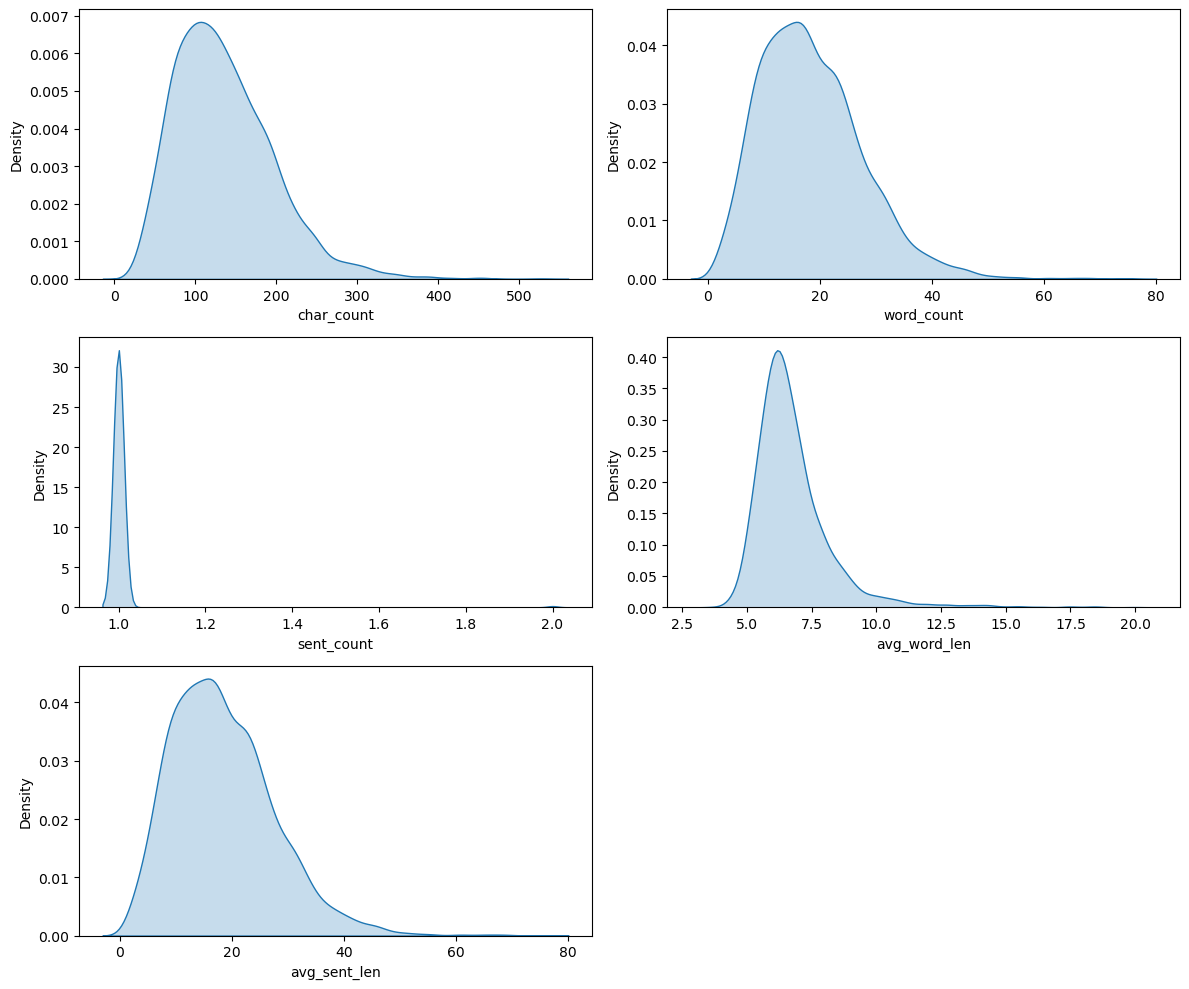

In [15]:
num_columns = 2
num_rows = 3

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))
axes = axes.ravel()

interesting_columns = ['char_count', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len']

# Generate KDE subplots for each column
for i, column in enumerate(interesting_columns[:5]):
    sns.kdeplot(data=df[column], shade=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')

# Remove the last subplot if there is an odd number of columns
if len(interesting_columns) % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust spacing and display the subplots
plt.tight_layout()
plt.show()

In [16]:
def create_corpus(df, column_name):
    stop = set(stopwords.words("english"))
    corpus = [word for i in df[column_name].str.split().values.tolist() for word in i if word not in stop]
    return corpus

In [17]:
corpus = create_corpus(df, "context_clean")

<AxesSubplot:>

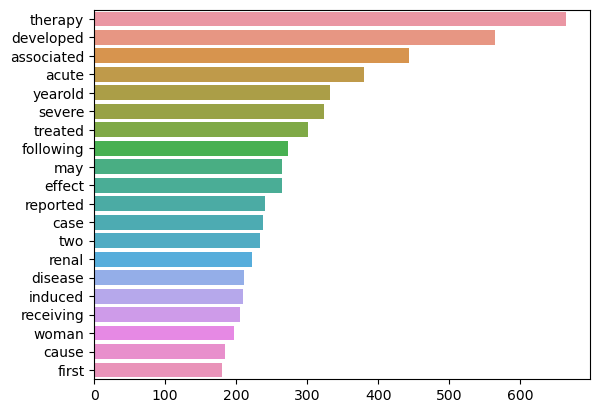

In [18]:
most_common = Counter(corpus).most_common(20)

words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

In [19]:
positive_event_to_match = 'Potential_therapeutic_event'
positive_df = df[df['event_type'] == positive_event_to_match]
positive_corpus = create_corpus(positive_df, "context_clean")

In [20]:
positive_df[0:5]

id                                            context  \
71    19537383_2  Sorafenib, a multitargeted kinase inhibitor us...   
80   23624139_10  Risks and benefits of co-treatment should be c...   
81    15685264_6  She had been treated by Carbamazepine 1000 mg/...   
91     7787496_1  Sotalol-induced bradycardia reversed by glucagon.   
114   10660641_2  A patient treated with itraconazole (ITCZ) und...   

                      event_type trigger_text           drug  \
71   Potential_therapeutic_event    treatment      Sorafenib   
80   Potential_therapeutic_event  recommended         NSAIDs   
81   Potential_therapeutic_event      treated  Carbamazepine   
91   Potential_therapeutic_event     reversed       glucagon   
114  Potential_therapeutic_event      treated   itraconazole   

                          drug_effect  sentiment  char_count  word_count  \
71                                NaN          0         174          23   
80   in order to improve DDAVP safety          0         188          28   
81                                NaN          0         132          21   
91                                NaN          0          49           5   
114                               NaN          0         143          17   

     sent_count  avg_word_len  avg_sent_len  \
71            1      6.608696          23.0   
80            1      5.750000          28.0   
81            1      5.333333          21.0   
91            1      9.000000           5.0   
114           1      7.470588          17.0   

                                         context_clean  \
71   sorafenib multitargeted kinase inhibitor used ...   
80   risk benefit cotreatment carefully considered ...   
81   treated carbamazepine mgday neuropathic pain y...   
91        sotalolinduced bradycardia reversed glucagon   
114  treated itraconazole itcz diagnosis aspergillu...   

                                            rare_words  
71   [carcinoma, sorafenib, multitargeted, kinase, ...  
80   [risk, cotreatment, carefully, considered, the...  
81   [treated, carbamazepine, mgday, neuropathic, p...  
91   [sotalolinduced, bradycardia, reversed, glucagon]  
114  [treated, itraconazole, itcz, diagnosis, asper...

<AxesSubplot:>

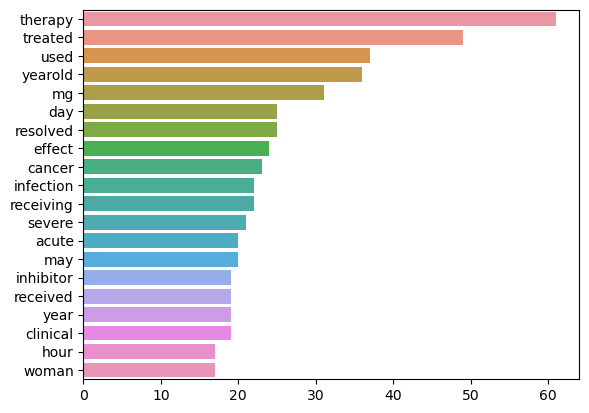

In [21]:
common_pos_words = Counter(positive_corpus).most_common(20)

words, frequency = [], []
for word, count in common_pos_words:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

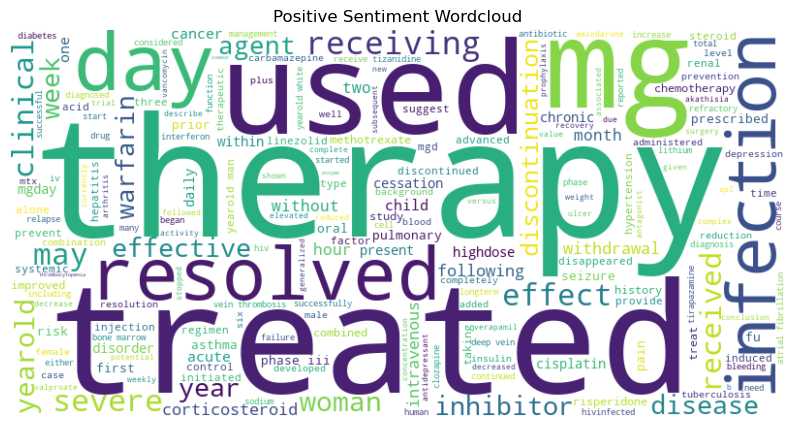

In [22]:
# Postive sentiment word cloud
text = ' '.join(positive_df['context_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Wordcloud')
plt.show()

In [23]:
negative_event_to_match = 'Adverse_event'
negative_df = df[df['event_type'] == negative_event_to_match]
negative_corpus = create_corpus(negative_df, "context_clean")

In [24]:
negative_df[0:5]

id                                            context  \
0    8908396_3  OBJECTIVE: To test the hypothesis that tumor n...   
1   10891991_1  An evaluation of ovarian structure and functio...   
2    2332596_1  Phenobarbital hepatotoxicity in an 8-month-old...   
3   12552054_1  The authors report a case of Balint syndrome w...   
4  19531695_12  According to the Naranjo probability scale, fl...   

      event_type trigger_text           drug  \
0  Adverse_event      induced        insulin   
1  Adverse_event      develop      valproate   
2  Adverse_event           in  Phenobarbital   
3  Adverse_event    following   methotrexate   
4  Adverse_event        cause     flecainide   

                                         drug_effect  sentiment  char_count  \
0                                      lipoatrophies          1         238   
1                       menstrual cycle disturbances          1         214   
2                                     hepatotoxicity          1          54   
3  Balint syndrome with irreversible posterior le...          1         150   
4                                           delirium          1         237   

   word_count  sent_count  avg_word_len  avg_sent_len  \
0          33           1      6.242424          33.0   
1          30           1      6.166667          30.0   
2           6           1      8.166667           6.0   
3          19           1      6.947368          19.0   
4          31           1      6.677419          31.0   

                                       context_clean  \
0  objective test hypothesis tumor necrosis facto...   
1  ovarian structure function considered woman re...   
2       phenobarbital hepatotoxicity monthold infant   
3  author balint irreversible posterior leukoence...   
4  according naranjo probability scale flecainide...   

                                          rare_words  
0  [objective, test, hypothesis, tumor, necrosis,...  
1  [ovarian, structure, function, considered, wom...  
2  [phenobarbital, hepatotoxicity, monthold, infant]  
3  [author, balint, irreversible, posterior, leuk...  
4  [probability, scale, flecainide, according, na...

<AxesSubplot:>

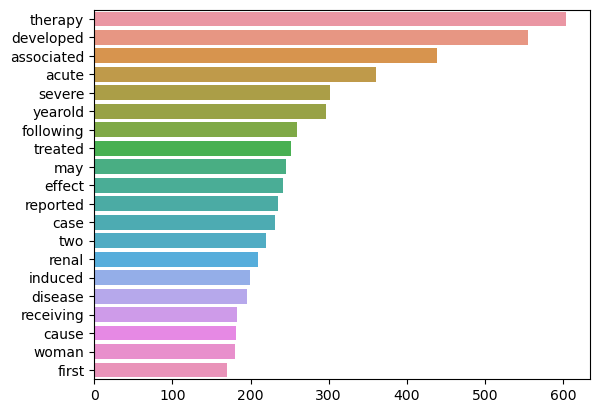

In [25]:
common_negative_words = Counter(negative_corpus).most_common(20)

words, frequency = [], []
for word, count in common_negative_words:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

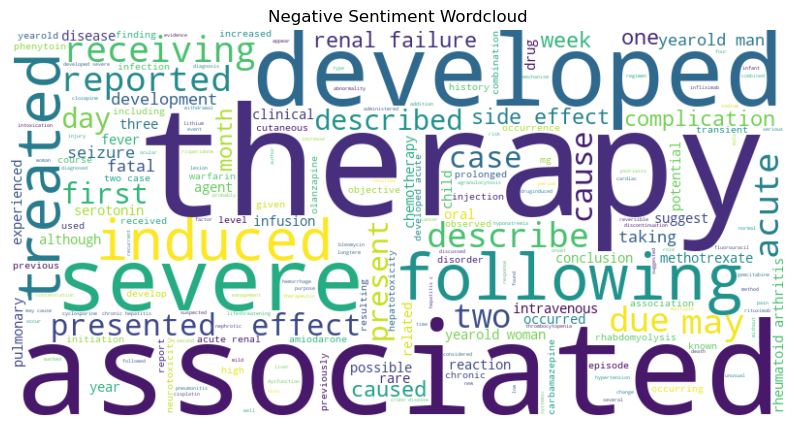

In [26]:
# Negative sentiment word cloud
text = ' '.join(negative_df['context_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Wordcloud')
plt.show()

In [27]:
def visualize_rare_words(dataframe, column_name, top_k=20):
    combined_text = ' '.join(dataframe[column_name].apply(lambda x: ' '.join(x)).astype(str))
    words = combined_text.split()

    words = [word for word in words if word not in string.punctuation]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    word_counts = pd.Series(words).value_counts().head(top_k).reset_index()
    word_counts.columns = ['Word', 'Frequency']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=word_counts, x='Word', y='Frequency', size='Frequency', hue='Frequency',
                    sizes=(50, 500), palette='Reds', legend=True)
    plt.xlabel('Rare Words')
    plt.ylabel('Frequency')
    plt.title('Top 20 Rare Words')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

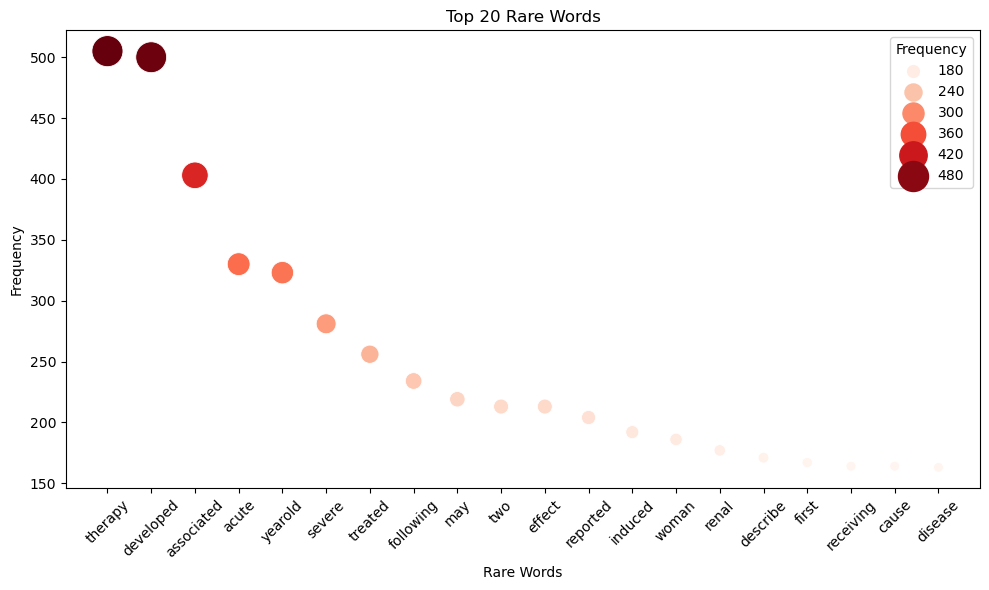

In [28]:
visualize_rare_words(df, 'rare_words', top_k=20)

In [29]:
def extract_top_ngrams(df, column_name, n_gram_range=(2, 3), top_n=10):
    vectorizer = CountVectorizer(ngram_range=n_gram_range)
    X = vectorizer.fit_transform(df[column_name])
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = X.sum(axis=0)
    sorted_ngrams = sorted([(count, ngram) for ngram, count in zip(feature_names, ngram_counts.tolist()[0])], 
                           reverse=True)
    
    result_df = pd.DataFrame(sorted_ngrams[:top_n], columns=['Frequency', 'N-gram'])
    return result_df

In [30]:
top_ngrams_df = extract_top_ngrams(df, 'context_clean', n_gram_range=(2, 2), top_n=10)
top_ngrams_df

Frequency                N-gram
0        104           side effect
1         93           yearold man
2         91         renal failure
3         85         yearold woman
4         71  rheumatoid arthritis
5         53              two case
6         50           acute renal
7         44       developed acute
8         42      developed severe
9         33     chronic hepatitis

In [31]:
top_neg_ngrams_df = extract_top_ngrams(negative_df, 'context_clean', n_gram_range=(2, 3), top_n=10)
top_neg_ngrams_df

Frequency                N-gram
0        100           side effect
1         89         renal failure
2         85           yearold man
3         83         yearold woman
4         69  rheumatoid arthritis
5         51              two case
6         50           acute renal
7         45   acute renal failure
8         44       developed acute
9         41      developed severe

In [32]:
top_pos_ngrams_df = extract_top_ngrams(positive_df, 'context_clean', n_gram_range=(2, 3), top_n=10)
top_pos_ngrams_df

Frequency                N-gram
0         10             phase iii
1          8           yearold man
2          6         yearold white
3          6       vein thrombosis
4          6  deep vein thrombosis
5          6             deep vein
6          6           bone marrow
7          6   atrial fibrillation
8          5           yearold boy
9          5        renal function

In [33]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Top N-grams for Negative Sentiment', 
                                                    'Top N-grams for Positive Sentiment'], 
                    horizontal_spacing=0.3, vertical_spacing=0.3)

fig.add_trace(go.Bar(x=top_neg_ngrams_df['Frequency'], y=top_neg_ngrams_df['N-gram'], 
                     orientation='h', name='Negative Sentiment', marker_color='red'), row=1, col=1)

fig.add_trace(go.Bar(x=top_pos_ngrams_df['Frequency'], y=top_pos_ngrams_df['N-gram'], 
                     orientation='h', name='Positive Sentiment', marker_color='blue'), row=1, col=2)

fig.update_layout(title='Comparison of Top N-grams for Positive and Negative Sentiment')
fig.show()

In [34]:
# overlapping statements ...
fig = go.Figure()

fig.add_trace(go.Bar(
    y=top_neg_ngrams_df['N-gram'],
    x=top_neg_ngrams_df['Frequency'],
    name='Negative Sentiment',
    orientation='h',
    marker_color='red'
))

fig.add_trace(go.Bar(
    y=top_pos_ngrams_df['N-gram'],
    x=top_pos_ngrams_df['Frequency'],
    name='Positive Sentiment',
    orientation='h',
    marker_color='blue'
))

fig.update_layout(
    title='Comparison of Top N-grams for Positive and Negative Sentiment',
    barmode='group'
)

fig.show()

In [35]:
def visualize_pos(dataframes, dataframe_names, column):
    pos_tags = ["ADJ"]

    # Download and load the spaCy English language model
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading language model. This may take a while...")
        spacy.cli.download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # Tokenize text and perform POS tagging
    tokenizer = twt()
    adjectives_by_dataframe = {}
    color_palette = cl.scales['12']['qual']['Set3']
    random.shuffle(color_palette)

    for i, dataframe in enumerate(dataframes):
        tokens = dataframe[column].apply(lambda x: tokenizer.tokenize(x))
        docs = tokens.apply(lambda x: nlp(" ".join(x)))
        tags = docs.apply(lambda doc: [token.lemma_ for token in doc if token.pos_ in pos_tags])
        adjectives = [adj for sublist in tags for adj in sublist]
        adjectives_counter = Counter(adjectives)
        top_adjectives = adjectives_counter.most_common(10)
        adjectives_by_dataframe[dataframe_names[i]] = top_adjectives

    # Create a bar chart for each dataframe
    fig = make_subplots(rows=len(dataframes), cols=1, subplot_titles=dataframe_names, vertical_spacing=0.3)

    for i, dataframe_name in enumerate(dataframe_names):
        top_adjectives = adjectives_by_dataframe[dataframe_name]
        x = [adj[0] for adj in top_adjectives]
        y = [adj[1] for adj in top_adjectives]
        colors = random.choices(color_palette, k=len(top_adjectives))

        fig.add_trace(go.Bar(x=x, y=y, marker=dict(color=colors)), row=i+1, col=1)

        # Add annotations to the bar chart for the top adjectives
        for xi, yi in zip(x, y):
            fig.add_annotation(
                x=xi,
                y=yi,
                text=str(yi),
                showarrow=False,
                font=dict(size=10)
            )

    fig.update_layout(title="Top 10 Adjectives by Dataframe",
                      xaxis_title="Top Adjective's",
                      yaxis_title="Count",
                      showlegend=False)

    fig.update_xaxes(tickangle=-45, tickfont=dict(size=8))
    fig.update_yaxes(tickfont=dict(size=8))

    fig.show()

In [36]:
dataframes = [negative_df, positive_df]
dataframe_names = ["Negative Sentiments", "Positive Sentiments"]
column = "context_clean"

visualize_pos(dataframes, dataframe_names, column)

In [37]:
wordcnt_sentiment_df = df[['word_count', 'sentiment']]

In [38]:
import plotly.graph_objects as go

# Create scatter plot using Plotly
fig = go.Figure()

# Add markers for positive sentiment
fig.add_trace(go.Scatter(
    y=wordcnt_sentiment_df[wordcnt_sentiment_df['sentiment'] == 0]['sentiment'],
    x=wordcnt_sentiment_df[wordcnt_sentiment_df['sentiment'] == 0]['word_count'],
    mode='markers',
    text=wordcnt_sentiment_df[wordcnt_sentiment_df['sentiment'] == 0]['word_count'],
    textposition='top center',
    marker=dict(color='blue', symbol='circle-open', size=10),
    name='Positive Sentiment'
))

# Add markers for negative sentiment
fig.add_trace(go.Scatter(
    y=wordcnt_sentiment_df[wordcnt_sentiment_df['sentiment'] == 1]['sentiment'],
    x=wordcnt_sentiment_df[wordcnt_sentiment_df['sentiment'] == 1]['word_count'],
    mode='markers',
    text=wordcnt_sentiment_df[wordcnt_sentiment_df['sentiment'] == 1]['word_count'],
    textposition='top center',
    marker=dict(color='red', symbol='x', size=10),
    name='Negative Sentiment'
))

# Set plot title and axis labels
fig.update_layout(
    title='Word Count by Sentiment',
    xaxis_title='Word Count',
    yaxis_title='Sentiment',
    width=900  # Adjust the width of the plot
)

# Show the plot
fig.show()
